In [1]:
#!pip install  webdataset gdown fast_pytorch_kmeans albumentations pytorch-fid
#!pip uninstall opencv-python -y
#!pip install opencv-python

In [2]:
#!gdown --folder https://drive.google.com/drive/u/2/folders/1d4aL0CCKMxS-WLO7RFFVXvCr57grgKF1 -O make_a_scene
#!mv make_a_scene/modules.py modules.py
#!mv make_a_scene/vqvae.py vqvae.py


In [3]:
import os
import yaml
import time
import torch
import matplotlib.pyplot as plt
from vqvae import VQBASE
import webdataset as wds
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.utils import make_grid, save_image
device = "cuda"

In [4]:
# Load configuration for the model
with open("make_a_scene/img_config.yaml", 'r') as file:
    params = yaml.safe_load(file)["model"]
    del params["_target_"]


# Initialize and load the second model in bfloat16
vq_vae = VQBASE(**params).to(device)
vq_vae.load_state_dict(torch.load("make_a_scene/checkpoint_63.0.pt", map_location=device)["model"])
vq_vae = vq_vae.to(dtype=torch.bfloat16)
vq_vae.eval().requires_grad_(False)


VQBASE(
  (encoder): Encoder(
    (model): Sequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ResnetBlock(
        (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): ResnetBlock(
        (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (3): Downsample(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
      )
      (4): ResnetBlock(
   

In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import webdataset as wds

def process_data(data):
    pretransforms = A.Compose([
        A.SmallestMaxSize(512),
        A.CenterCrop(512, 512, always_apply=True),
        ToTensorV2()
    ])
    data["jpg"] = pretransforms(image=data["jpg"])["image"]
    # Convert image to bfloat16
    data["jpg"] = data["jpg"].to(torch.bfloat16)
    return data

url = "file:make_a_scene/00000.tar"
dataset = wds.WebDataset(url).decode("rgb").map(process_data).to_tuple("jpg", "txt")

def collate(batch):
    images = torch.stack([i[0] for i in batch], dim=0)
    captions = [i[1] for i in batch]
    return [images, captions]

loader = torch.utils.data.DataLoader(dataset, batch_size=1, collate_fn=collate)


In [6]:
images = next(dataset.iterator())[0].unsqueeze(0)
images = images.to(device)

with torch.no_grad():
    s = time.time()

    # Directly obtain the embeddings without initially reshaping
    discrete_tokens = vq_vae.encode(images)[2]

    # Embed the discrete tokens and tranpose it
    embeddings_T = vq_vae.quantize.embedding(discrete_tokens).T

    # Transform into latent shape
    vectorized_latent = embeddings_T.view(1, -1, 32, 32) 

    #Reconstructed the image
    reconstructed_image = vq_vae.decode(vectorized_latent)



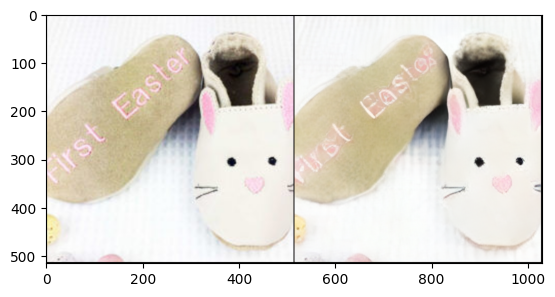

In [19]:
# Original image
images = images[:1]

# Reconstructed image
reconstructed_image = reconstructed_image[:1]

#Print out comparision
rec_all = make_grid(torch.concat([images, reconstructed_image]), nrow=2)
plt.imshow(rec_all.to(torch.float32).detach().cpu().permute(1, 2, 0).numpy())
plt.show()
